# Gemma - AI Assistant for Common Questions About Python Programming Language

In this notebook Google's Gemma 2B language model is finetuned for answering common questions about Python.
This notebook was developed for the [Google – AI Assistants for Data Tasks with Gemma](https://www.kaggle.com/competitions/data-assistants-with-gemma) competition.

First we install the packages required to download and run Gemma. These first few set-up steps are copied from this [notebook](https://www.kaggle.com/code/nilaychauhan/fine-tune-gemma-models-in-keras-using-lora/notebook) published by Nilay Chauhan.

(Originally written and run in kaggle notebook. You are required to request access to Gemma model on kaggle before downloading.)

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [2]:
import os
import keras
import keras_nlp

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import logging
#import warning
#logging.getLogger().setLevel(logging.ERROR)
#warnings.filterwarnings("ignore")

2024-04-15 11:07:43.672654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 11:07:43.672866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 11:07:43.840130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

In [4]:
# Keras settings
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

In [5]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

Now that we have loaded in our pretrained model, we can do a simple to test to see how the model responds to a basic programming problem - reversing a string.

We can see that the model returns the correct answer, but is more verbose than necessary, and at a certain point the text become repetitive. Next we will see how we can finetune the model to polish the format of the response.

In [6]:
# Test inference before finetuning
prompt = "Instruction:\nHow do I reverse a string in Python?\n\nResponse:\n"
print(gemma_lm.generate(prompt, max_length=256))

I0000 00:00:1713179379.757210      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-15 11:09:39.757641: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-15 11:09:39.758141: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


Instruction:
How do I reverse a string in Python?

Response:
The reverse() method reverses a string.

Syntax:
string.reverse()

Example:
>>> s = "Hello World"
>>> s.reverse()
>>> s
'dlrow olleH'

Output:
dlrow olleH

Explanation:
The reverse() method reverses a string.
The reverse() method reverses the string in place.
The reverse() method returns the reversed string.
The reverse() method does not modify the original string.
The reverse() method does not return a new string.
The reverse() method does not raise an exception.
The reverse() method does not throw an exception.
The reverse() method does not return a reference to the original string.
The reverse() method does not return a copy of the original string.
The reverse() method does not return a copy of the original string.
The reverse() method does not return a copy of the original string.
The reverse() method does not return a copy of the original string.
The reverse() method does not return a copy of the original string.
The rev

We will use a dataset containing questions and answers from stack overflow related to the python programming language for the finetuning process.

After quickly reviewing the data format, we can see that we have information on both the title of the each question and further details about the question in the "body" column. We also note that there are multiple answers recorded to some questions. These questions and answers will be paired accordingly:

"Question:\n{Title}\n\nAnswer:{Body}"

"Question:\n{Body}\n\nAnswer:{Body}"

We also have information about the quality of the questions and answers from the score values. This represents the upvotes/downvotes that the posts received on stackoverflow. We should select data entries with higher scores because this should correspond with higher quality data. My analysis is that answer score is much more important than question score. The answer will contain information which could potentially be incorrect, and so a high score gives us more confidence that it is correct. Another reason for this is that people have a tendency to downvote obvious questions, but we want our model to be able to respond to these obvious questions, so there could still be value in including questions with low scores.

In [7]:
data = []
questions_df = pd.read_csv("/kaggle/input/pythonquestions/Questions.csv", encoding='latin-1')
answers_df = pd.read_csv("/kaggle/input/pythonquestions/Answers.csv", encoding='latin-1')
questions_df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [8]:
print(questions_df.shape[0], answers_df.shape[0])
answers_df.head()

607282 987122


,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


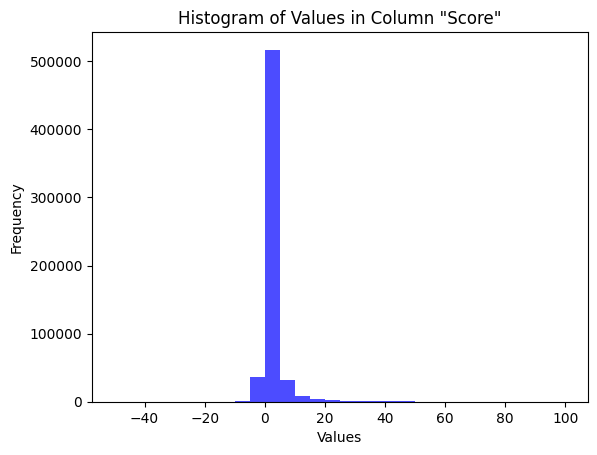

[     0      0      1      0      1      3      5     22    144  16039
 849194  76530  18700   7915   4507   2791   2025   1414   1109    869
    693    550    465    366    354    299    281    224    179    187]
[     0      1      0      1      0      0      6     17    691  35594
 516857  32427   8843   3933   2210   1363   1000    641    548    389
    311    283    221    182    158    135    113    104     72     81]


In [9]:
# Quick analysis of data quality according to StackOverflow users
hist_a, bins_a = np.histogram(answers_df["Score"], bins=30, range=(-50,100))
hist_q, bins_q = np.histogram(questions_df["Score"], bins=30, range=(-50,100))

plt.hist(questions_df["Score"], bins=30, range=(-50, 100), color="blue", alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values in Column "{}"'.format("Score"))
plt.show()
print(hist_a)
print(hist_q)

In [10]:
sorted_q = questions_df.sort_values(by="Score")
test = sorted_q.head()
for index, row in test.iterrows():
    answer = answers_df[answers_df["ParentId"] == row["Id"]]
    if not answer.empty:
        print("Question:")
        print(row["Score"], row["Title"])
        print("Answer Upvotes:")
        for i, r in answer.iterrows():
            print(r["Score"], len(r["Body"]))
test

Question:
-44 How to collate attribute values stored as dicts within a list?
Answer Upvotes:
4 192
-26 477
4 324
-1 278
Question:
-32 How to multiply the same number? (x^2)
Answer Upvotes:
10 1239
Question:
-19 Recursive to iterative using a systematic method
Answer Upvotes:
3 5270
Question:
-18 I would like to split this into a list but i don't know how(in python)
Answer Upvotes:
1 445
Question:
-18 What is equivalent of Python's time.time() in perl?
Answer Upvotes:
2 142


,Id,OwnerUserId,CreationDate,Score,Title,Body
313949,25970488,2955338.0,2014-09-22T09:16:37Z,-44,How to collate attribute values stored as dict...,<p>In my list each element is a dict of the fo...
392603,30402552,4674272.0,2015-05-22T17:24:40Z,-32,How to multiply the same number? (x^2),<p>I need a program in Python that would read ...
568352,38567618,3809375.0,2016-07-25T12:20:48Z,-19,Recursive to iterative using a systematic method,"<p>I've started reading the book <em><a href=""..."
427036,32191198,4864486.0,2015-08-24T20:29:31Z,-18,I would like to split this into a list but i d...,<p>I have this string </p>\n\n<pre><code>var(H...
326305,26724585,4212189.0,2014-11-03T22:38:03Z,-18,What is equivalent of Python's time.time() in ...,<p>what is the Perl equivalent of Python's tim...


Now we filter our dataset to narrow down the number of examples used in our training data for finetuning. I decided to consider all answers with 5 or more upvotes as valid training data. We also filter out answers that are much longer than we want our model to produce.

In [11]:
# Filter out all answers that have a score of less than 5
# Filter out answers that are above max sequence length threshold
# Remove all but the highest scoring answer remaining
score_threshold = 5
max_seq_length = 256
filtered_answers_df = answers_df[(answers_df["Score"] >= score_threshold) & (answers_df["Body"].str.len() <= max_seq_length)]
idx = filtered_answers_df.groupby("ParentId")["Score"].idxmax()
filtered_answers_df = filtered_answers_df.loc[idx]
print(filtered_answers_df.shape[0], filtered_answers_df["Score"].max())
filtered_answers_df.head()


16927 2388


,Id,OwnerUserId,CreationDate,ParentId,Score,Body
19,1484,2089740.0,2008-08-04T18:34:45Z,1476,57,<pre><code>&gt;&gt;&gt; print int('01010101111...
23,1852,116.0,2008-08-05T03:11:55Z,1829,6,<p><strong>On Windows:</strong></p>\n\n<pre><c...
27,1879,116.0,2008-08-05T04:13:53Z,1854,91,<p>For the record here's the results on Mac:</...
29,1987,269.0,2008-08-05T07:27:40Z,1983,19,"<p>The list [1,2,3] is dynamic and flexible bu..."
31,2316,259.0,2008-08-05T13:45:38Z,2311,14,<p>Do you need to open the locfile in binary u...


In [12]:
# Sample a subset of rows with a higher weighting to higher scores
sample_size = 1000
max_value = filtered_answers_df["Score"].max()
probabilities = filtered_answers_df["Score"] / max_value
sampled_answers_df = filtered_answers_df.sample(n=sample_size, replace=True, weights=probabilities)

# Pair the filtered answers with corresponding questions
merged_df = pd.merge(sampled_answers_df[['ParentId', 'Body']], questions_df[['Id', 'Title', 'Body']], left_on='ParentId', right_on='Id', how='inner')
merged_df.head()

,ParentId,Body_x,Id,Title,Body_y
0,11475885,<p>No. Regular expressions in Python are handl...,11475885,python .replace() regex,<p>I am trying to do a grab everything after t...
1,1218933,<pre><code>from cStringIO import StringIO\nimp...,1218933,Can I redirect the stdout in python into some ...,<p>I'm using python's <code>ftplib</code> to w...
2,7703865,<p>Writing something like this should convert ...,7703865,Going from twitter date to Python datetime date,<p>I am receiving twitter messages that are se...
3,940089,<p>You can use the setattr function to dynamic...,940089,How do I update an object's members using a dict?,<p>I'm writing a Django app that performs vari...
4,7283599,<p>The example will produce all combinations o...,7283599,Python traversing two lists,<p>I found this nice statement in a tutorial:<...


In [13]:
# Format training data
html_tags_pattern = re.compile(r"<[^>]+>")
training_data = []
for i, row in merged_df.iterrows():
    title, q, a = row["Title"], row["Body_y"], row["Body_x"]
    datapoint = f"Question:\n{title} {q}\n\nAnswer:\n{a}"
    datapoint = re.sub(html_tags_pattern, '', datapoint) # remove html tags from data
    training_data.append(datapoint)
print(training_data[10])

# Free up some memory
del questions_df, answers_df, sorted_q, test, sampled_answers_df, merged_df

Question:
Do JavaScript arrays have an equivalent of Pythonâs âif a in listâ? If I have a list in Python, I can check whether a given value is in it using the in operator:

&gt;&gt;&gt; my_list = ['a', 'b', 'c']

&gt;&gt;&gt; 'a' in my_list
True

&gt;&gt;&gt; 'd' in my_list
False


If I have an array in JavaScript, e.g.

var my_array = ['a', 'b', 'c'];


Can I check whether a value is in it in a similar way to Pythonâs in operator, or do I need to loop through the array?


Answer:
var my_array = ['a', 'b', 'c'];
alert(my_array.indexOf('b'));
alert(my_array.indexOf('dd'));


if element not found, you will receive -1



In [14]:
# Enable LoRA for the model and set the LoRA rank to 4.
# This limits the number of trainable parameters
gemma_lm.backbone.enable_lora(rank=4)

In [15]:
# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = 128
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-6,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(training_data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18168s 18s/step - loss: 2.0359 - sparse_categorical_accuracy: 0.5487


Now test finetuned model. If we use the same prompt that we tried previously with the pretrained model, we can see that the finetuned model offers a more concise response. However, when passed other prompts, we can see that the model is still unnecessarily repetitive. The model would likely perform better if we were to finetune it with a longer input sequence length - improving context recognition by lengthening the context window during the finetuning process. It would also be beneficial to increase the number of examples used during finetuning (only 1000 out of nearly 17,000 filtered examples were used).

In [16]:
prompt = "Instruction:\nHow do I reverse a string in Python?\n\nResponse:\n"
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
How do I reverse a string in Python?

Response:
The reverse() method reverses a string.

Syntax:
string.reverse()

Example:
>>> s = "Hello World"
>>> s.reverse()
>>> s
'dlroW olleH'

Output:
dlroW olleH

Explanation:
The reverse() method reverses a string.



In [19]:
prompt = "Instruction:\nHow do you sort a list without built-in function in python?\n\nResponse:\n"
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
How do you sort a list without built-in function in python?

Response:
You can use the sorted() function to sort a list.

The sorted() function takes a list as an argument and returns a sorted list.

The sorted() function sorts the list in ascending order by default.

You can also specify the sort order by passing a second argument to the sorted() function.

The sort order can be either "ascending" or "descending".

The sort order can also be specified by passing a third argument to the sorted() function.

The sort order can be either "ascending", "descending", or "reverse".

The sort order can also be specified by passing a fourth argument to the sorted() function.

The sort order can be either "ascending", "descending", "reverse", or "random".

The sort order can also be specified by passing a fifth argument to the sorted() function.

The sort order can be either "ascending", "descending", "reverse", "random", or "quicksort".

The sort order can also be specified by pass